In [1]:
import io
import os
import re
import sys
import csv
import gzip
import glob
import time
import secrets
import multiprocessing
import subprocess
import resource
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import patchworklib as pw
import scipy as sp
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
sys.path.append('/well/band/users/rbx225/software/QUILT_test/QUILT/Python/')
import lcwgsus
from lcwgsus.variables import *
from hla_phase_functions import *
from hla_align_functions import *

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
from scipy.stats import power_divergence, chi2_contingency
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

# HBA, GYP, BSG, ACKR

In [24]:
variants = pd.DataFrame(columns = ['chr', 'pos', 'ID', 'ref', 'alt', 'MAF'])

HbS = [11, 5227002, 'rs334', 'T', 'A', 0.0494]
HbC = [11, 5227003, 'rs33930165', 'C', 'T', 0.01452]
O = [9, 133257521, 'rs8176719', 'T', 'TC', 0.3030]
ATP2B4 = [8, 697972, 'rs1075451', 'C', 'T', 0.5743]

genes = [HbS, HbC, O, ATP2B4]
for g in genes:
    variants.loc[len(variants)] = g

In [28]:
chip = '../archive/GAMCC_old/imputation_comparison/vanilla/chip_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
lc = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'

variants['r2_lc'] = 0
variants['r2_chip'] = 0

for i, v in enumerate(genes):
    c, pos, ref, alt = v[0], v[1], v[3], v[4]
    tmp1 = pd.read_csv(chip + 'chr' + str(c) + '.h.tsv', sep = '\t')
    tmp1 = tmp1[(tmp1['pos'] == pos) & (tmp1['ref'] == ref) & (tmp1['alt'] == alt)]
    if len(tmp1) == 0:
        r2 = 0
    else:
        r2 = tmp1['r2'].values
    variants.loc[i, 'r2_lc'] = r2
    
    tmp2 = pd.read_csv(chip + 'chr' + str(c) + '.h.tsv', sep = '\t')
    tmp2 = tmp2[(tmp2['pos'] == pos) & (tmp2['ref'] == ref) & (tmp2['alt'] == alt)]
    if len(tmp2) == 0:
        r2 = 0
    else:
        r2 = tmp2['r2'].values
    variants.loc[i, 'r2_chip'] = r2

In [29]:
variants

,chr,pos,ID,ref,alt,MAF,r2_lc,r2_chip
0,11,5227002,rs334,T,A,0.04940,-9.000000,-9.000000
1,11,5227003,rs33930165,C,T,0.01452,-9.000000,-9.000000
2,9,133257521,rs8176719,T,TC,0.30300,0.000000,0.000000
3,8,697972,rs1075451,C,T,0.57430,0.953185,0.953185


In [2]:
regions = pd.DataFrame(columns = ['chr', 'start', 'end', 'gene'])

# HBA1 = [16, 176680, 177522, 'HBA1']
# HBA2 = [16, 172876, 173710, 'HBA2']
GYPA = [4, 144109303, 144140751, 'GYPA']
GYPB = [4, 143996104, 144019380, 'GYPB'] 
GYPE = [4, 143870864, 143905563, 'GYPE']

BSG = [19, 571277, 583494, 'BSG']
ACKR1 = [1, 159203307, 159206500, 'ACKR1']

genes = [GYPA, GYPB, GYPE, BSG, ACKR1]
# genes = [HBA1, HBA2, GYPA, GYPB, GYPE, BSG, ACKR1]

for g in genes:
    regions.loc[len(regions)] = g

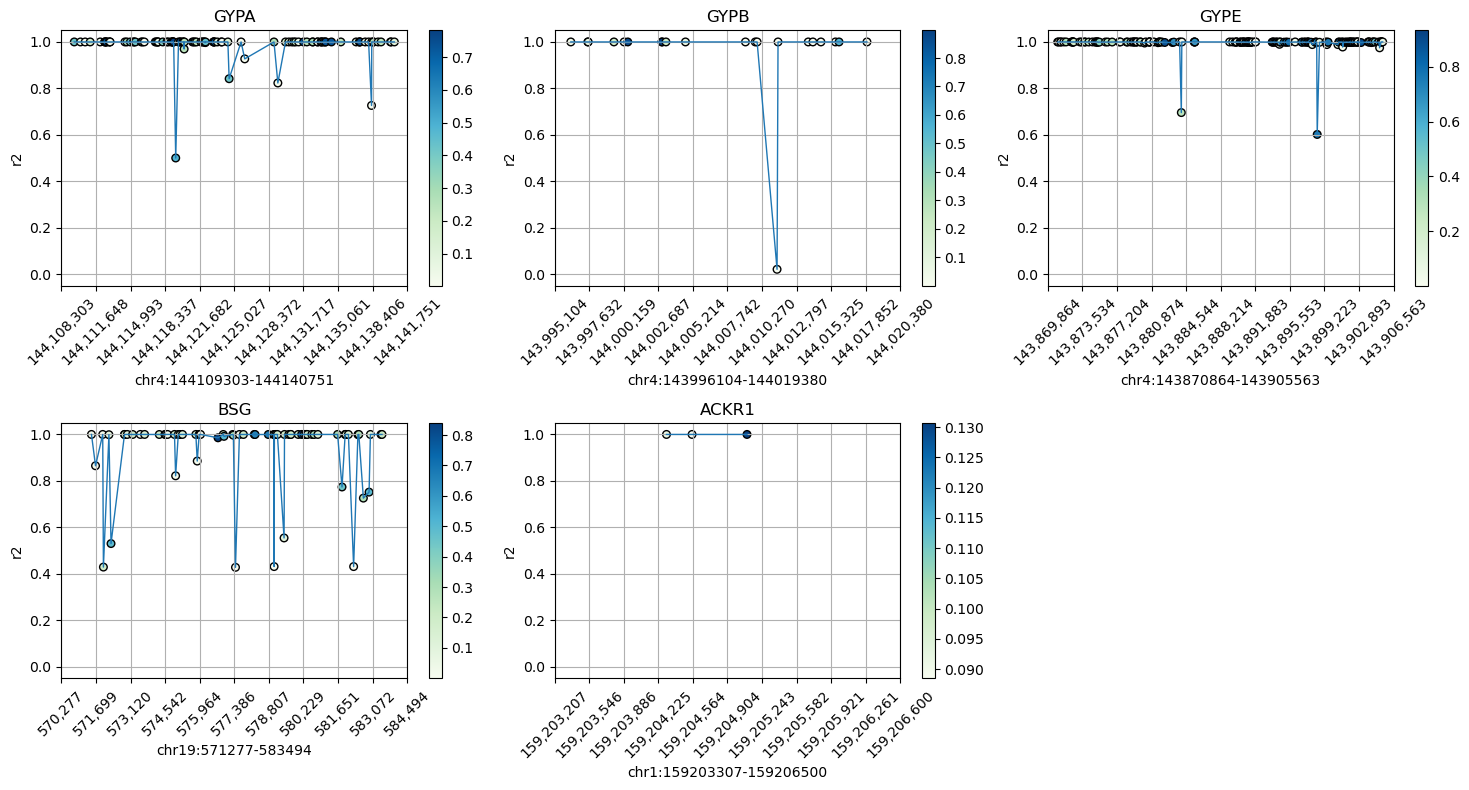

In [4]:
imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

nrow = 2
ncol = 3
ngraph = len(regions)
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = tuple(regions.loc[i].values)
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

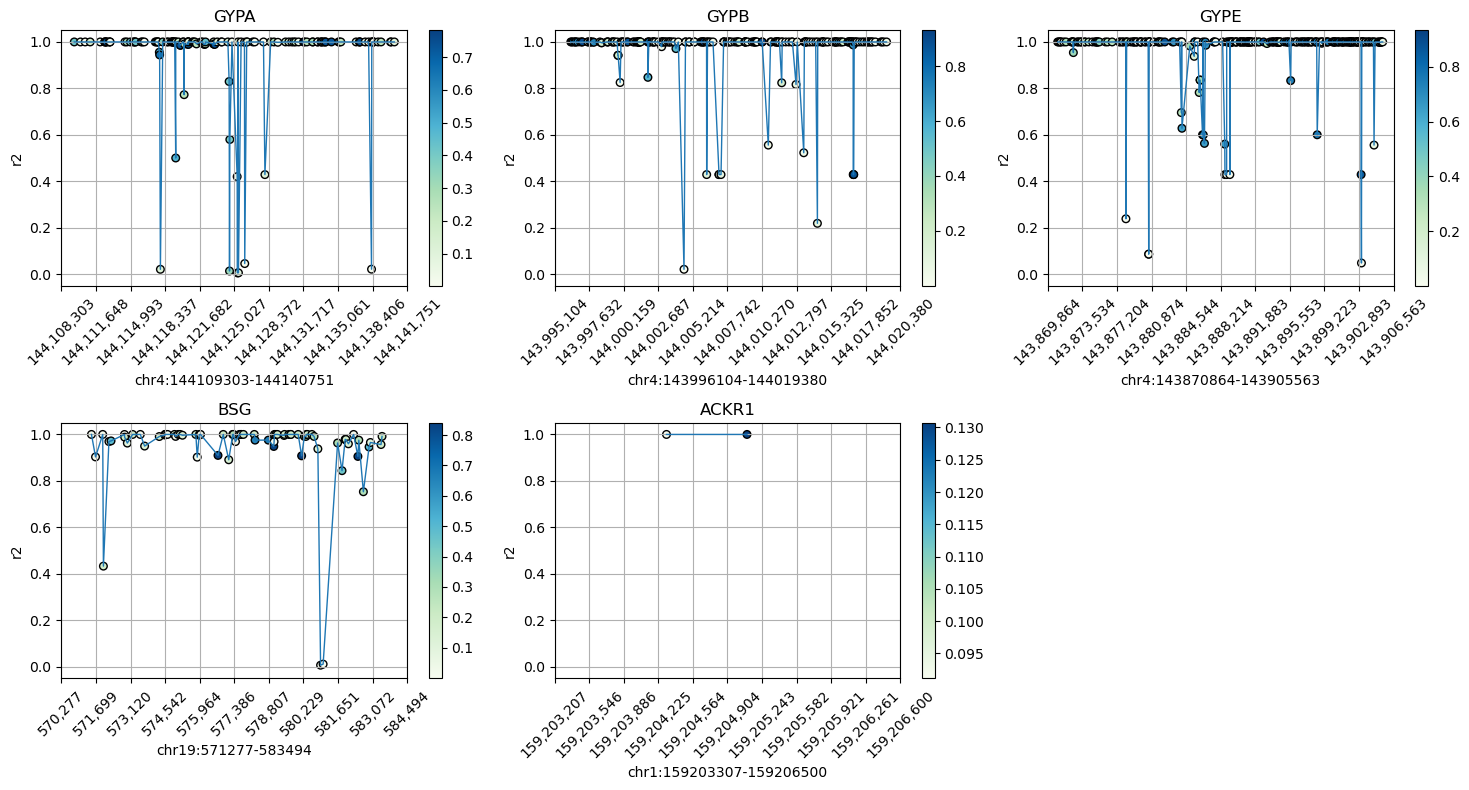

In [5]:
imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

nrow = 2
ncol = 3
ngraph = len(regions)
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = tuple(regions.loc[i].values)
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# Blood group variants

In [12]:
genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)

variants = pd.read_csv('data/blood_group_variants/blood_group_variants.tsv', sep = '\t', index_col = False)
variants

,chr,pos,ID,ref,alt,MAF
0,11,5227002,rs334,T,A,0.04940
1,11,5227003,rs33930165,C,T,0.01452
2,9,133257521,rs8176719,T,TC,0.30300
3,8,697972,rs1075451,C,T,0.57430


## lc vs chip (N=210)

In [92]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

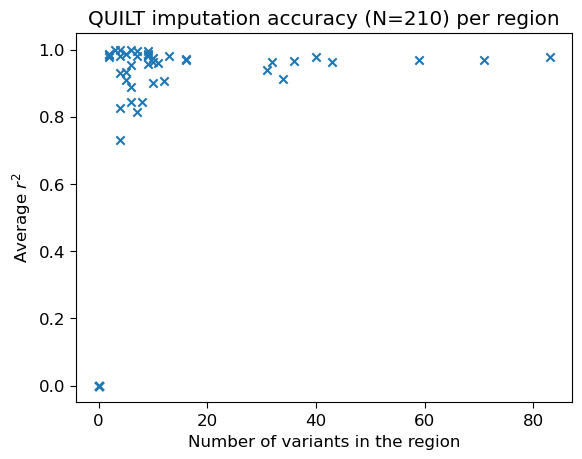

In [93]:
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/impacc/all_samples/by_variant/'
# hs = []
# for i in CHROMOSOMES_ALL:
#     t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
#     hs.append(t)
# h = pd.concat(hs)
# # h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
# h = h[h['r2'] != -9]

region = genes.copy()

region['r2'] = 0
region['n_variants'] = 0
# region['rho_variants'] = 0 # Density
for i in range(len(genes)):
    c,s,e,t = region.iloc[i, :4]
    tmp = h[h['chr'] == c]
    tmp = tmp[tmp['r2'] != -9]

    df = tmp[(tmp['pos'] < e) & (tmp['pos'] > s)]
    if len(df) == 0:
        pass
    else:
        region.loc[i, 'r2'] = df['r2'].mean()
        region.loc[i, 'n_variants'] = len(df)
#         region['rho_variants'] = 1000*len(df)/(e-s)

plt.scatter(region['n_variants'], region['r2'], marker = 'x')
plt.xlabel('Number of variants in the region')
plt.ylabel('Average $r^2$')
plt.title('QUILT imputation accuracy (N=210) per region')
plt.show()

In [94]:
region.sort_values(by = 'r2')

,chr,start,end,gene,r2,n_variants
23,6,31982057,32002681,C4A,0.000000,0
28,1,159203307,159206500,ACKR1,0.000000,0
7,1,25272393,25330445,RHD,0.000000,0
16,1,3772749,3775982,SMIM1,0.000000,0
10,6,32014795,32035418,C4B,0.000000,0
14,19,10286955,10288522,ICAM4,0.000000,0
13,7,30911853,30925517,AQP1,0.731524,4
4,19,44809071,44821421,BCAM,0.813823,7
20,19,48748011,48755390,FUT1,0.824941,4
18,17,44248390,44268141,SLC4A1,0.843631,6


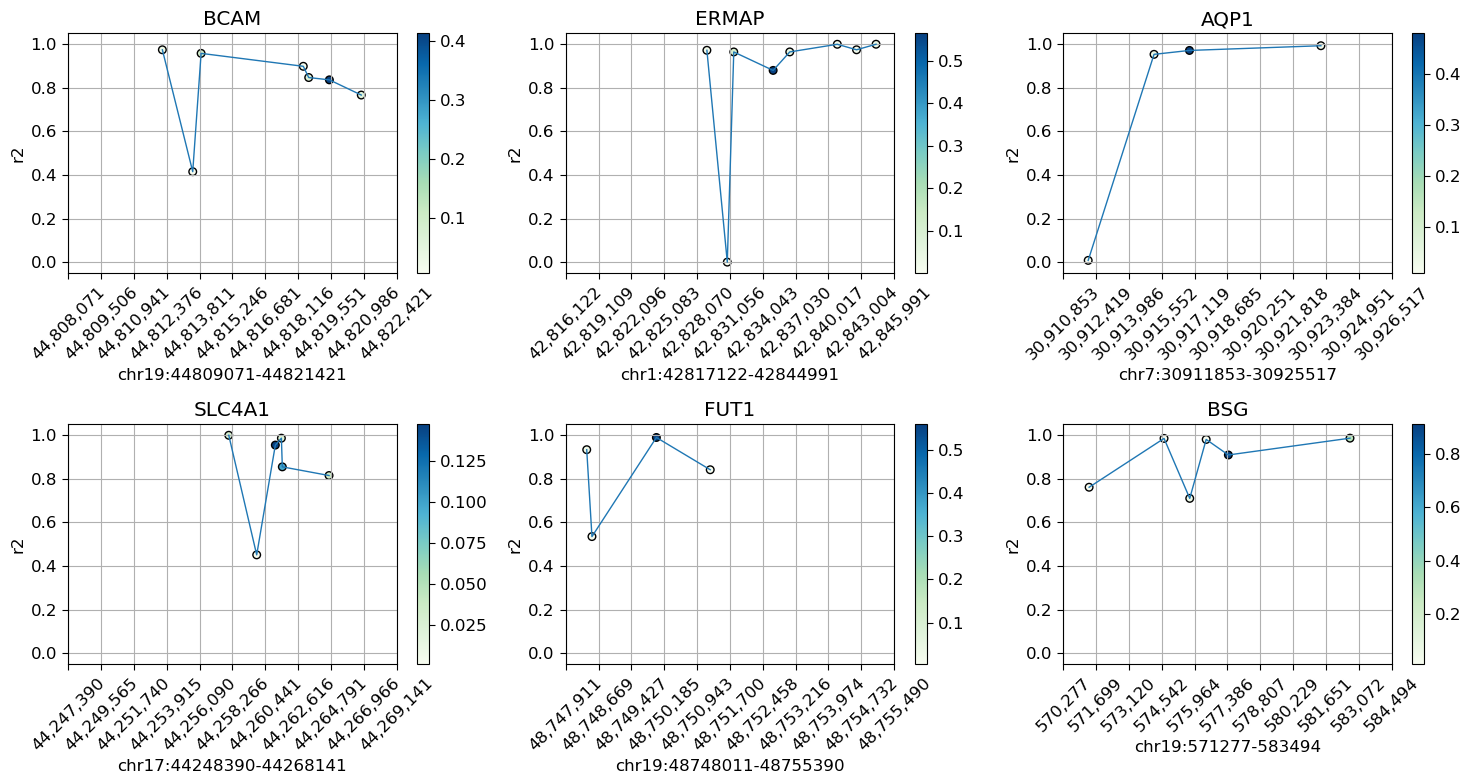

In [95]:
filtered_region = region[region['r2'] != 0]
filtered_region = filtered_region[filtered_region['r2'] < 0.9].reset_index(drop = True)

ngraph = len(filtered_region)
ncol = 3
nrow = ngraph//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = filtered_region.iloc[i, :4]
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

In [20]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in CHROMOSOMES_ALL:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]

x = pd.merge(variants, h[COMMON_COLS + ['r2']], on = COMMON_COLS, how = 'left')
x

,chr,pos,ID,ref,alt,MAF,r2
0,11,5227002,rs334,T,A,0.04940,0.947045
1,11,5227003,rs33930165,C,T,0.01452,-9.000000
2,9,133257521,rs8176719,T,TC,0.30300,NaN
3,8,697972,rs1075451,C,T,0.57430,NaN


## two-stage TOPMed (N=8)

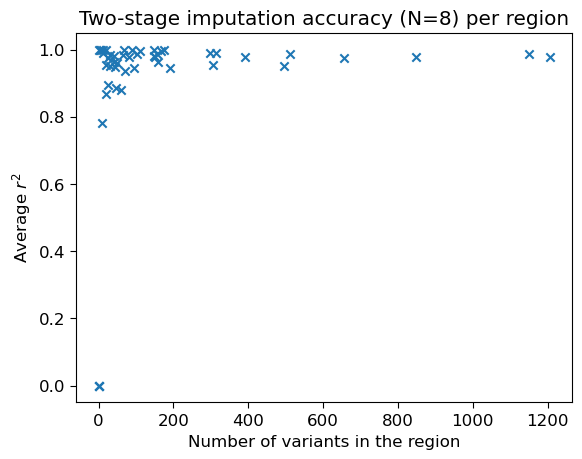

In [41]:
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
# hs = []
# for i in CHROMOSOMES_ALL:
#     t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
#     hs.append(t)
# h = pd.concat(hs)
# # h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
# h = h[h['r2'] != -9]

region = genes.copy()

region['r2'] = 0
region['n_variants'] = 0
# region['rho_variants'] = 0 # Density
for i in range(len(genes)):
    c,s,e,t = region.iloc[i, :4]
    tmp = h[h['chr'] == c]
    tmp = tmp[tmp['r2'] != -9]

    df = tmp[(tmp['pos'] < e) & (tmp['pos'] > s)]
    if len(df) == 0:
        pass
    else:
        region.loc[i, 'r2'] = df['r2'].mean()
        region.loc[i, 'n_variants'] = len(df)
#         region['rho_variants'] = 1000*len(df)/(e-s)

plt.scatter(region['n_variants'], region['r2'], marker = 'x')
plt.xlabel('Number of variants in the region')
plt.ylabel('Average $r^2$')
plt.title('Two-stage imputation accuracy (N=8) per region')
plt.show()

In [42]:
region.sort_values(by = 'r2')

,chr,start,end,gene,r2,n_variants
23,6,31982057,32002681,C4A,0.000000,0
10,6,32014795,32035418,C4B,0.000000,0
7,1,25272393,25330445,RHD,0.000000,0
16,1,3772749,3775982,SMIM1,0.782069,8
12,19,5842888,5851471,FUT3,0.866521,19
36,9,133152948,133163933,GBGT1,0.879873,61
13,7,30911853,30925517,AQP1,0.886378,46
40,20,4686350,4701590,PRNP,0.893519,24
26,19,571277,583494,BSG,0.937023,70
34,19,10602457,10644557,SLC44A2,0.945755,95


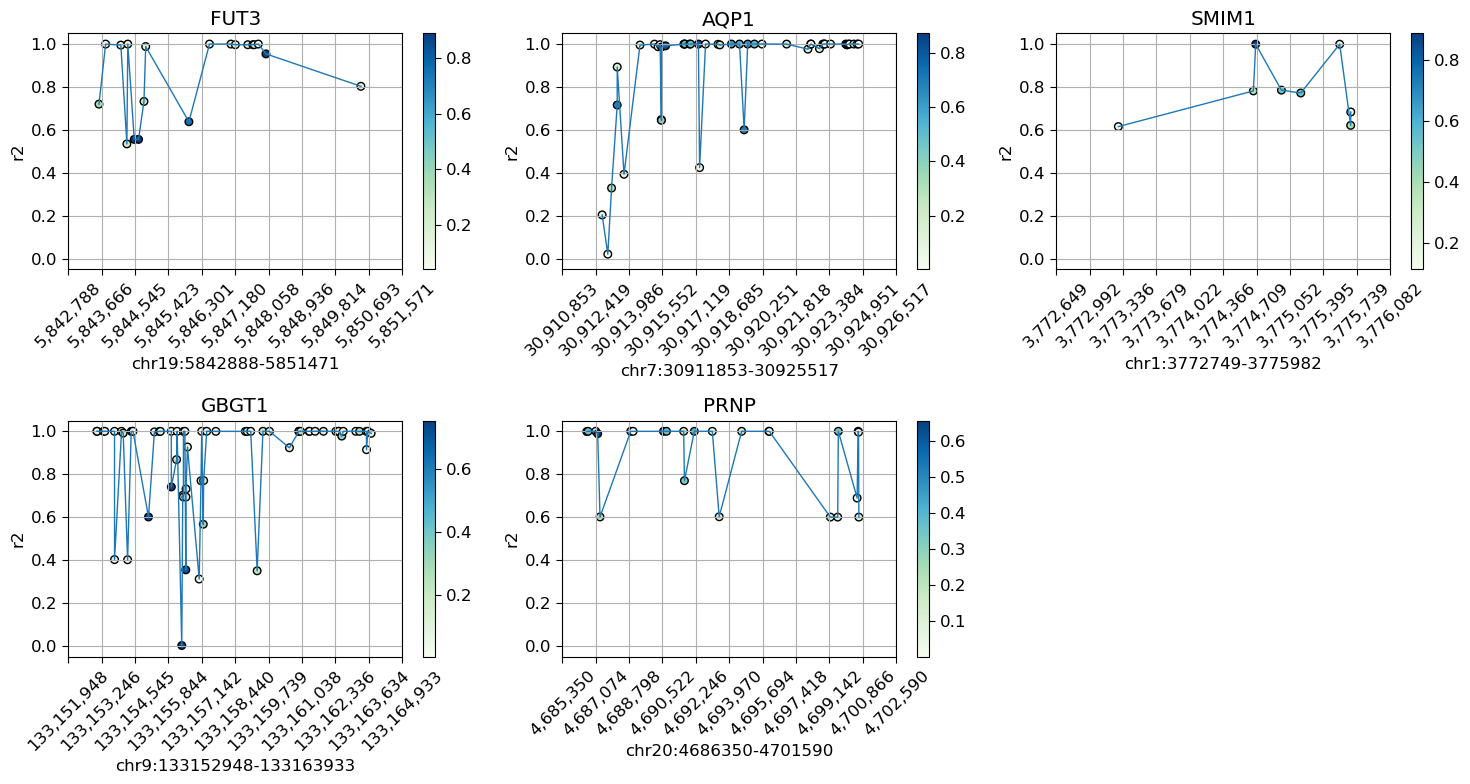

In [46]:
filtered_region = region[region['r2'] != 0]
filtered_region = filtered_region[filtered_region['r2'] < 0.9].reset_index(drop = True)

ngraph = len(filtered_region)
ncol = 3
nrow = ngraph//ncol + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(15,8))

for i in range(nrow*ncol):
    row = i // (nrow + 1)
    col = i % ncol
    if i < ngraph:
        c, s, e, t = filtered_region.iloc[i, :4]
        lcwgsus.plot_imputation_metric_in_region(h, chr=c, pos=0, start=s, end=e, title=t, show_fig=True, ax=axes[row, col])
    else:
        fig.delaxes(axes[row, col])
        
plt.tight_layout()
plt.show()

In [19]:
imp_dir = 'results/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
# imp_dir = '../archive/GAMCC_old/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/impacc/all_samples/by_variant/'
hs = []
cs = [8,9,11]
for i in cs:
    t = pd.read_csv(imp_dir + 'chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)
# h = h[(h[['NRC', 'r2', 'ccd_het', 'ccd_homalt']] != -9.).any(axis = 1)]
h = h[h['r2'] != -9]

x = pd.merge(variants, h[COMMON_COLS + ['r2']], on = COMMON_COLS, how = 'left')
x

,chr,pos,ID,ref,alt,MAF,r2
0,11,5227002,rs334,T,A,0.04940,NaN
1,11,5227003,rs33930165,C,T,0.01452,NaN
2,9,133257521,rs8176719,T,TC,0.30300,0.999990
3,8,697972,rs1075451,C,T,0.57430,0.999984


# Generate GAMCC sample files from PCs

In [12]:
output = "results/gwas/mGenv1_topmed/vcf/blood_groups.sample"

metadata = pd.read_csv('data/metadata/GAMCC-lcWGS_metadata.csv')
metadata = metadata[['anon_id', 'Status_v1']]
fv_gam_names = lcwgsus.read_tsv_as_lst('data/sample_tsvs/chip_gam_names.tsv')
metadata = metadata[metadata['anon_id'].isin(fv_gam_names)]
metadata.columns = ['ID', 'malaria']
metadata['malaria'] = metadata['malaria'].map({'Mild malaria': 'mild', 'Non-malaria control': 'control', 'Severe malaria': 'severe'})
metadata = metadata.reset_index(drop = True)

n_PCs = 4
PCs = pd.read_csv('results/wip_vcfs/oneKG/vanilla/chip_sites/PCs.eigenvec', sep = ' ', header = None)
PCs = PCs.iloc[:,1:(n_PCs + 2)]
PCs.columns = ['ID'] + [f'PC{i}' for i in range(1,(n_PCs + 1))]
for c in PCs.columns[1:]:
    PCs[c] = PCs[c].astype(str)

sample = pd.merge(metadata, PCs, on = 'ID')
sample.loc[-1] = ['0', 'D', 'C', 'C', 'C', 'C']
sample.index = sample.index + 1  # Shift the index up
sample = sample.sort_index()
# sample.to_csv(output, sep = ' ', index = False, header = True)
sample

,ID,malaria,PC1,PC2,PC3,PC4
0,0,D,C,C,C,C
1,GAM164079,mild,-0.0100833,-0.0071255,-0.00871895,-0.0134307
2,GAM348792,mild,-0.0142579,-0.00609422,0.000648936,-0.0264409
3,GAM079168,mild,0.00929311,0.0162228,-0.0295332,0.00081663
4,GAM086135,mild,0.0729333,0.0611522,-0.0602697,0.0409489
...,...,...,...,...,...,...
182,GAM538491,control,-0.0264708,-0.0140068,0.00443773,-0.0191258
183,GAM718643,control,-0.0222351,-0.009263,0.00769271,-0.0132733
184,GAM682513,control,-0.00632338,0.00582276,-0.011034,-0.0187107
185,GAM013627,control,-0.0388369,-0.028094,0.016678,-0.0125207


# GWAS

## Common variables and functions

In [21]:
genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

In [22]:
def plot_gwas_sumstat_col(annot, col = 'frequentist_gen_lrt_pvalue', title = ''):
    data = annot[['rsid', 'region', 'chromosome', 'position', col]]
    data.columns = ['SNP', 'Region', 'CHR', 'BP', 'P']

    data['-log10(P)'] = -np.log10(data['P'])
    data = data.sort_values(['CHR', 'BP'], ascending = True).reset_index(drop=True)
    data['cumulative_BP'] = 0

    gap = 30000
    tmp_max_idx = 0

    tmp_lst = []
    for region, region_data in data.groupby('Region', sort = False):
        region_data = region_data.copy()
        region_data['BP'] = region_data['BP'] - region_data['BP'].min() + tmp_max_idx + gap
        tmp_max_idx = region_data['BP'].max()
        tmp_lst.append(region_data)

    data = pd.concat(tmp_lst)
    significance_threshold = -np.log10(5e-8)

    plt.figure(figsize=(12, 6))
    colors = ['#1076ae', '#60c1f6']
    for i, (region_name, region_data) in enumerate(data.groupby('Region', sort = False)):
        plt.scatter(
            region_data['BP'], region_data['-log10(P)'],
            c=colors[i % 2], s=10, label=region_name if i < 2 else None
        )

    xticks = []
    xlabels = []
    for region, region_data in data.groupby('Region', sort = False):
        middle = region_data['BP'].median()
        xticks.append(middle)
        xlabels.append(region)

    plt.xticks(ticks=xticks, labels=xlabels, fontsize=10, rotation=90)
    plt.xlabel('Genes', fontsize=12)
    plt.ylabel('-log10(P)', fontsize=12)
    plt.title(title)

    plt.tight_layout()
    plt.show()

In [29]:
af_files = [f'data/gnomAD_MAFs/afr/gnomAD_MAF_afr_chr{i}.txt' for i in CHROMOSOMES_ALL]
af = lcwgsus.multi_read_af(CHROMOSOMES_ALL, af_files)
af['chr'] = 'chr' + af['chr'].astype(str)
af.columns = ['chromosome', 'position', 'ref', 'alt', 'MAF']

,chr,pos,ref,alt,MAF
0,1,10031,T,C,0.0
1,1,10037,T,C,0.0
2,1,10043,T,C,0.000044
3,1,10055,T,C,0.0
4,1,10057,A,C,0.000033
...,...,...,...,...,...
315440192,22,50808276,AGGGGTTAG,A,0.5
315440193,22,50808277,G,C,0.02381
315440194,22,50808296,A,C,0.5
315440195,22,50808302,A,C,0.5


## Chip vs Lc (N=186); additive; case = severe+mild

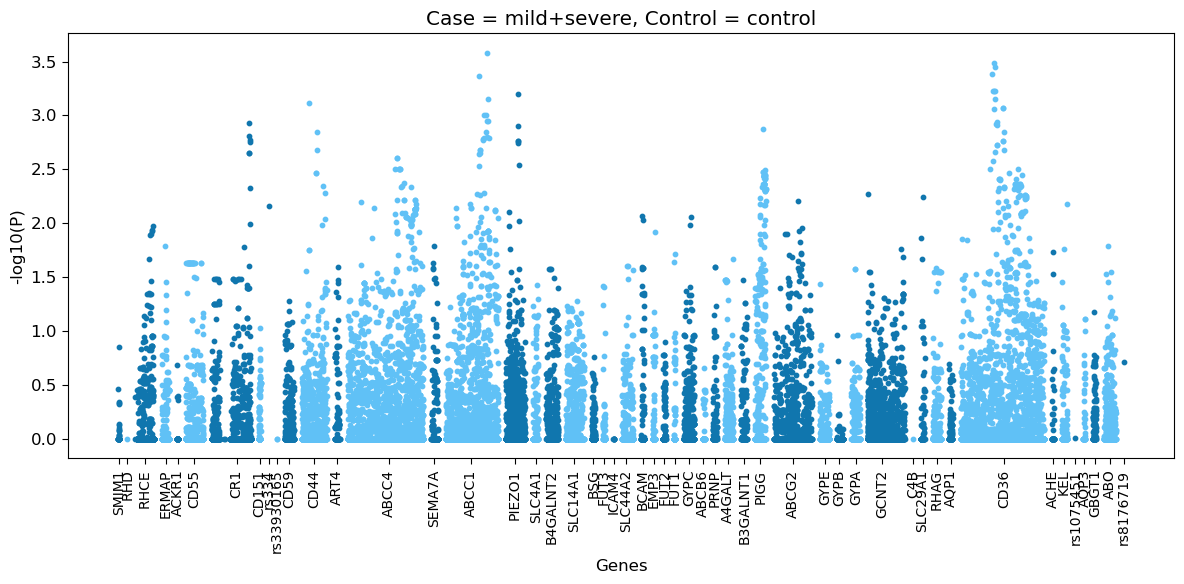

In [79]:
sumstat_lc = pd.read_csv('results/gwas/mGenv1_topmed/lr1/lc/results/stats.out', sep = '\t', comment = '#')

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat_lc[(sumstat_lc['chromosome'] == f'chr{c}') & (sumstat_lc['position'] <= e) & (sumstat_lc['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_dom_wald_pvalue_1'] > 1e-50]

threshold = 0.01
annot_lc = pd.merge(annot, af, on = ['chromosome', 'position'])

def flip_maf(r):
    if r['alleleA'] == r['alt']:
        r['MAF'] = 1 - r['MAF']
    return r

annot_lc = annot_lc.apply(flip_maf, axis = 1)
annot_lc = annot_lc[annot_lc['MAF'] > threshold]

plot_gwas_sumstat_col(annot_lc, col = 'frequentist_dom_wald_pvalue_1', title = 'Case = mild+severe, Control = control')

In [106]:
command = "bcftools view -r chr11:5227002-5227002 /well/band/users/rbx225/GAMCC/results/gwas/mGenv1_topmed/lr1/lc/vcf/blood_groups.vcf.gz"

snp_haps = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
snp_haps = [i.split('\t') for i in snp_haps if '##' not in i]
snp_haps = pd.DataFrame(snp_haps)
snp_haps.columns = snp_haps.iloc[0]  # Set the first row as the header
snp_haps = snp_haps[1:].reset_index(drop = True)

snp_haps = snp_haps.drop(columns = ['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
snp_haps = snp_haps[(snp_haps['REF'].str.len() == 1) & (snp_haps['ALT'].str.len() == 1)]
snp_haps = snp_haps.rename(columns = {'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
snp_haps['snp'] = (snp_haps['pos'].astype(str) + snp_haps['ref'] + snp_haps['alt']).values
snp_haps['pos'] = snp_haps['pos'].astype(int)
retained_samples = lcwgsus.read_tsv_as_lst('data/sample_tsvs/chip_gam_names.tsv')
snp_haps = snp_haps[retained_samples]
AAs = []
for s in retained_samples:
    snp_haps[s] = snp_haps[s].str.split(':').str.get(0)
    genotype = snp_haps.loc[1, s]
    dosage = int(genotype.split('|')[0]) + int(genotype.split('|')[1])
    snp_haps[s] = dosage
    if dosage == 2:
        AAs.append(s)

metadata = pd.read_csv('data/metadata/GAMCC-lcWGS_metadata.csv')
metadata = metadata[['anon_id', 'Status_v1']]
fv_gam_names = lcwgsus.read_tsv_as_lst('data/sample_tsvs/chip_gam_names.tsv')
metadata = metadata[metadata['anon_id'].isin(fv_gam_names)]
metadata.columns = ['ID', 'malaria']
# metadata['malaria'] = metadata['malaria'].map({'Mild malaria': 1, 'Non-malaria control': 0, 'Severe malaria': 1})
metadata = metadata.reset_index(drop = True)
metadata[metadata['ID'].isin(AAs)]

,ID,malaria
76,GAM297614,Non-malaria control
97,GAM135209,Severe malaria
145,GAM592361,Non-malaria control
157,GAM275896,Non-malaria control
168,GAM514987,Non-malaria control


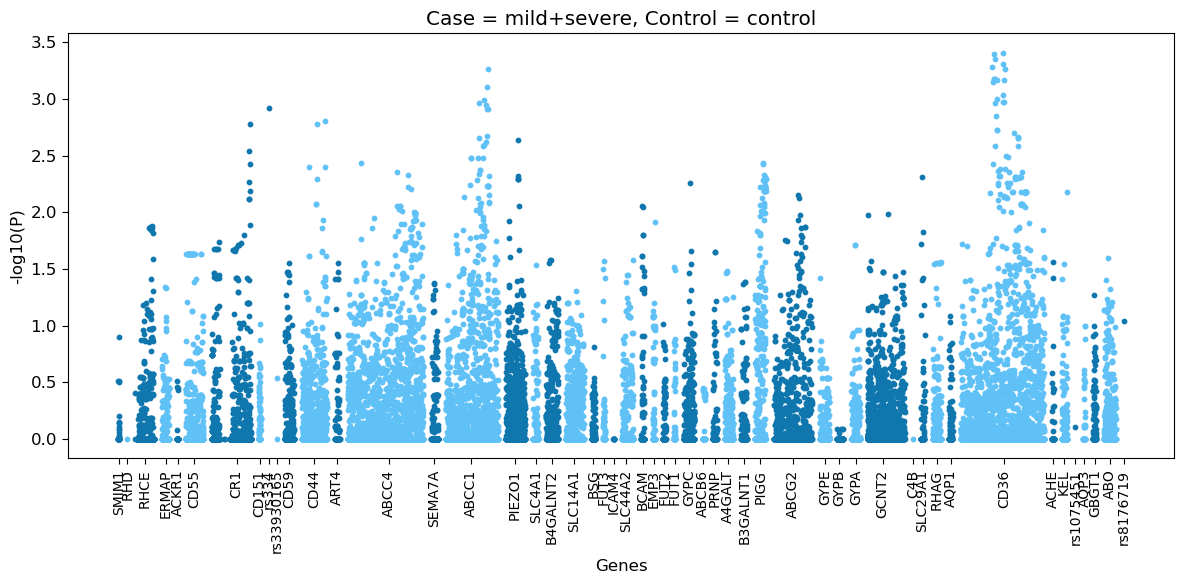

In [52]:
sumstat_chip = pd.read_csv('results/gwas/mGenv1_topmed/lr1/chip/results/stats.out', sep = '\t', comment = '#')

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat_chip[(sumstat_chip['chromosome'] == f'chr{c}') & (sumstat_chip['position'] <= e) & (sumstat_chip['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_dom_wald_pvalue_1'] > 1e-50]

threshold = 0.01
annot_chip = pd.merge(annot, af, on = ['chromosome', 'position'])

def flip_maf(r):
    if r['alleleA'] == r['alt']:
        r['MAF'] = 1 - r['MAF']
    return r

annot_chip = annot_chip.apply(flip_maf, axis = 1)
annot_chip = annot_chip[annot_chip['MAF'] > threshold]

plot_gwas_sumstat_col(annot_chip, col = 'frequentist_dom_wald_pvalue_1', title = 'Case = mild+severe, Control = control')

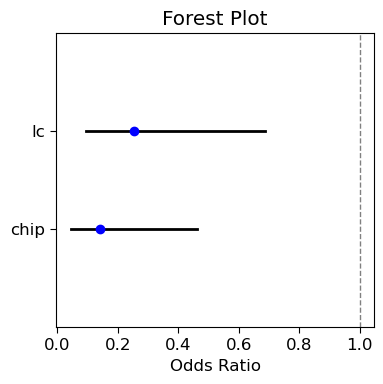

In [108]:
studies = ['lc', 'chip']

beta_lc = annot_lc[annot_lc['rsid'] == 'rs334']['frequentist_dom_beta_1:dom/malaria=1'].values[0]
se_lc = annot_lc[annot_lc['rsid'] == 'rs334']['frequentist_dom_se_1'].values[0]
beta_chip = annot_chip[annot_chip['rsid'] == 'rs334']['frequentist_dom_beta_1:dom/malaria=1'].values[0]
se_chip = annot_chip[annot_chip['rsid'] == 'rs334']['frequentist_dom_se_1'].values[0]
z = 1.96 

effect_sizes = [np.exp(beta_lc), np.exp(beta_chip)]
conf_intervals = [(np.exp(beta_lc + z * se_lc), np.exp(beta_lc - z * se_lc)), 
                  (np.exp(beta_chip + z * se_chip), np.exp(beta_chip - z * se_chip))]

fig, ax = plt.subplots(figsize=(4,4))
for i, (effect, (ci_low, ci_high)) in enumerate(zip(effect_sizes, conf_intervals)):
    ax.plot([ci_low, ci_high], [i, i], color='black', linestyle='-', lw=2)
    ax.scatter(effect, i, color='blue', zorder=3)

# Add labels
ax.set_yticks(range(len(studies)))
ax.set_yticklabels(studies)
ax.axvline(1, color='gray', linestyle='--', lw=1)
ax.set_xlabel('Odds Ratio')
ax.set_title('Forest Plot')
ax.set_ylim((-1,2))

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

## Multinomial Logistic Regression

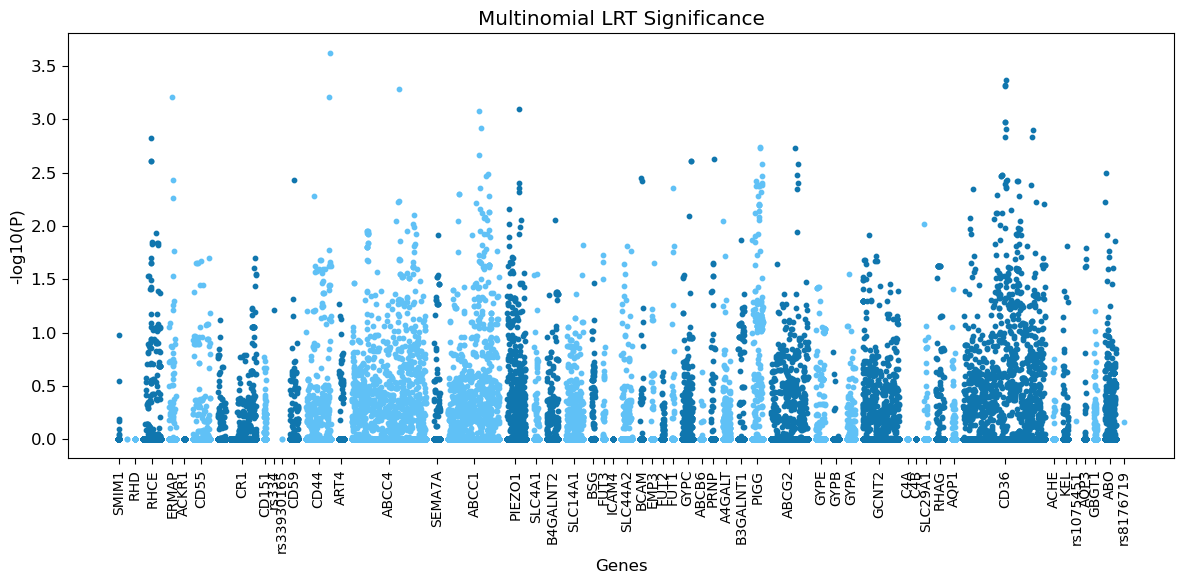

In [37]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/mlr/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)

plot_gwas_sumstat_col(annot, title = 'Multinomial LRT Significance')

In [38]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_wald_pvalue_4,frequentist_gen_wald_pvalue_5,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.802762,0.846282,0.18455,0.961922,4.0,0.061733,7.0,0.0,1,rs334


## Logistic Regression (Case = mild+severe, Control = control)

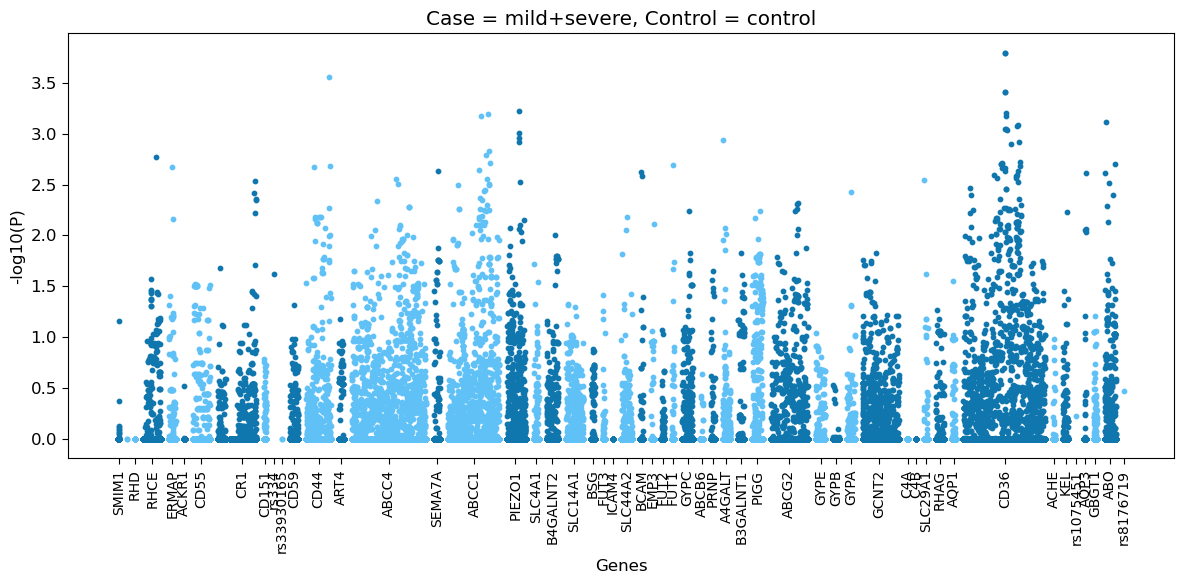

In [43]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr1/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = mild+severe, Control = control')

In [44]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.73604,-0.306109,0.050179,0.710242,2.0,0.024061,2.0,0.0,1,rs334


## Logistic Regression (Case = severe, Control = control + mild)

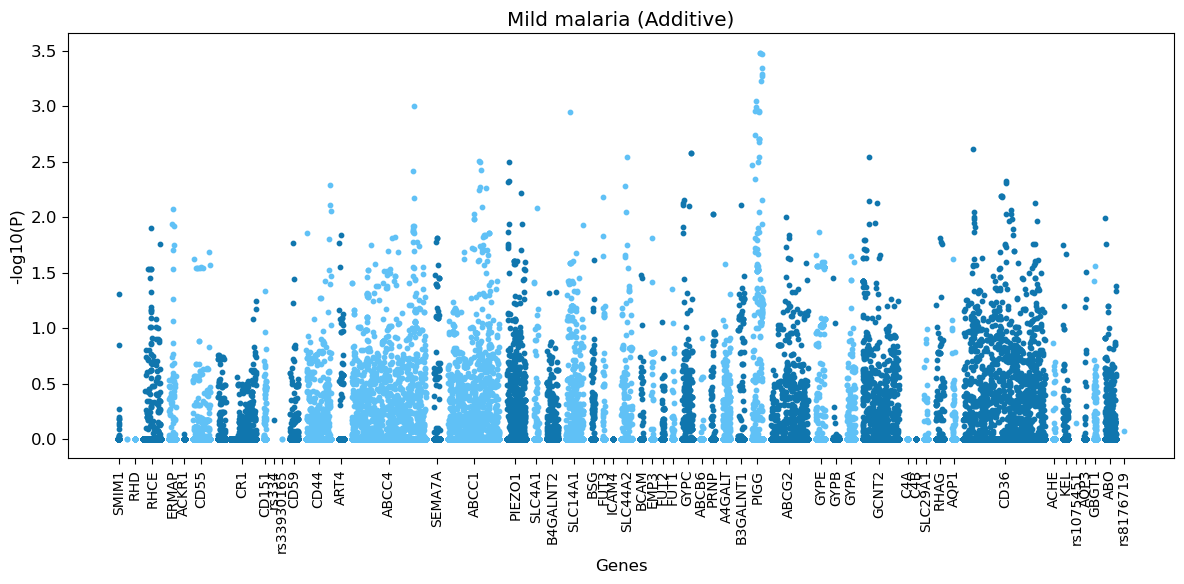

In [45]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr2/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = severe, Control = control + mild')

In [46]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,186.988,...,0.772576,-0.306048,0.516804,0.942257,2.0,0.678656,2.0,0.0,1,rs334


## Logistic Regression (Case = severe, Control = control)

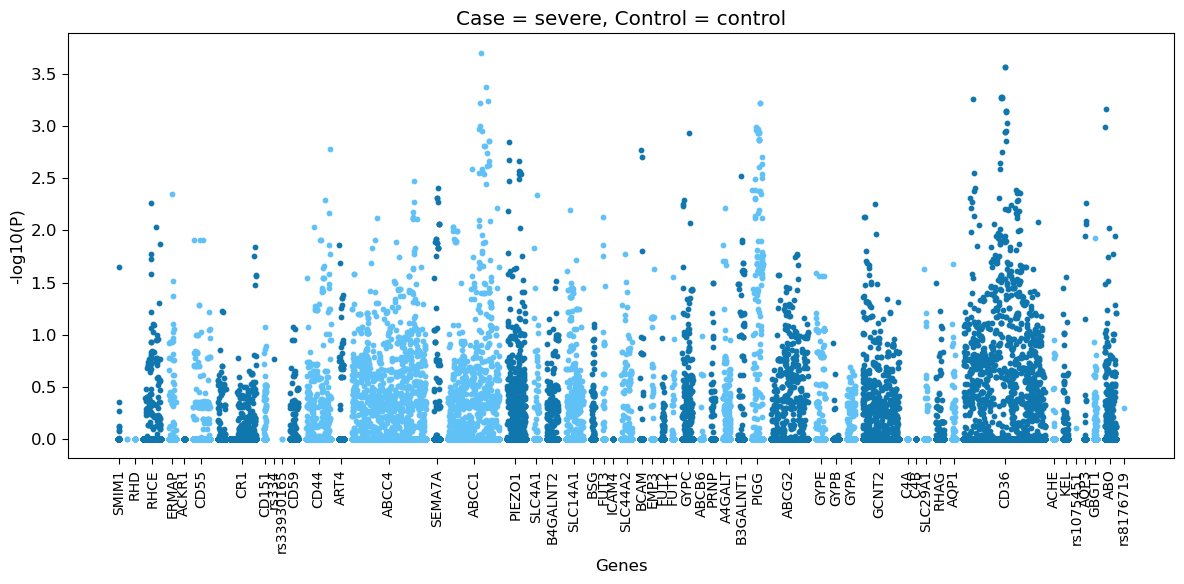

In [50]:
sumstat = pd.read_csv('results/gwas/mGenv1_topmed/lr3/results/stats.out', sep = '\t', comment = '#')

genes = pd.read_csv('data/blood_group_variants/blood_group_genes.tsv', sep = '\t', index_col = False)
genes = genes[genes['Chromosome'] != 'X'].reset_index(drop = True)
genes = genes.iloc[:,[1,2,3,0]]
genes.columns = ['chr', 'start', 'end', 'gene']
genes['chr'] = genes['chr'].astype(int)
genes.loc[len(genes)] = [11, '5227002', '5227002', 'rs334']
genes.loc[len(genes)] = [11, '5227003', '5227003', 'rs33930165']
genes.loc[len(genes)] = [9, '133257521', '133257521', 'rs8176719']
genes.loc[len(genes)] = [8, '697972', '697972', 'rs1075451']
genes['start'] = genes['start'].astype(int)
genes['end'] = genes['end'].astype(int)
genes = genes.sort_values(by = ['chr', 'start'], ascending = True).reset_index(drop = True)

for i in range(len(genes)):
    c, s, e, g = tuple(genes.iloc[i,:])
    tmp = sumstat[(sumstat['chromosome'] == f'chr{c}') & (sumstat['position'] <= e) & (sumstat['position'] >= s)]
    tmp['region'] = g
    
    if i == 0:
        annot = tmp
    else:
        annot = pd.concat([annot, tmp])
annot = annot.fillna(1)
annot = annot[annot['frequentist_gen_wald_pvalue_1'] > 1e-50]

plot_gwas_sumstat_col(annot, title = 'Case = severe, Control = control')

In [52]:
annot[annot['rsid'].isin(['rs334'])]

,alternate_ids,rsid,chromosome,position,alleleA,alleleB,incorrectly_coded,all_A,all_B,all_AA,...,frequentist_gen_se_2,"frequentist_gen_cov_1,2",frequentist_gen_wald_pvalue_1,frequentist_gen_wald_pvalue_2,frequentist_gen_degrees_of_freedom,frequentist_gen_lrt_pvalue,frequentist_gen_iterations,frequentist_gen_fit_time,comment,region
187003,rs8176719,rs8176719,chr9,133257521,T,TC,1.0,0,0,56.8668,...,0.374268,-0.035719,0.781799,0.336225,2.0,0.499915,1.0,0.0,1,ABO
187003,rs8176719,rs8176719,chr9,133257521,T,TC,1.0,0,0,56.8668,...,0.374268,-0.035719,0.781799,0.336225,2.0,0.499915,1.0,0.0,1,rs8176719
191448,rs334,rs334,chr11,5227002,T,A,1.0,0,0,120.9920,...,0.795341,-0.302378,0.186072,0.966759,2.0,0.171451,2.0,0.0,1,rs334
